# Part 1 - Data Visualization and k-NN
In the first three parts, you will work with the GalaxyMNIST dataset. This dataset comprises images of galaxies coupled with class labels and we aim to build the best possible classifier.
In this first part you should get to know the data, implement a simple k-NN classifier and write your own evaluation. 

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import urllib
import shutil
import torch
import gzip

try:
    from galaxy_mnist import GalaxyMNIST
except ImportError:
    !pip install git+https://github.com/mwalmsley/galaxy_mnist.git
    from galaxy_mnist import GalaxyMNIST

download_data = [{"url":"https://www.dropbox.com/scl/fi/l4ap5eq7z49l27dnfw076/train_dataset.hdf5.gz?rlkey=gjfrrrouoah0hbydbkpfx66as&st=tw6znd55&dl=1", "zipfile": "train_dataset.hdf5.gz", "file": "train_dataset.hdf5"},
{"url": "https://www.dropbox.com/scl/fi/ty43vhrrpa8cf8azn3awn/test_dataset.hdf5.gz?rlkey=jmlkzjiguhe271nbuzpa0njna&st=5oco8ika&dl=1", "zipfile": "test_dataset.hdf5.gz","file": "test_dataset.hdf5"}]

root_folder = Path("raw_galaxy_mnist")
download_folder = root_folder / "GalaxyMNIST" / "raw"
download_folder.mkdir(parents=True, exist_ok=True)
for info in download_data:
    if not (download_folder / info["file"]).exists(): # Check if data exists, if not download and unpack
        urllib.request.urlretrieve(info["url"], download_folder / info["zipfile"])
        with gzip.open(download_folder / info["zipfile"], 'rb') as f_in:
            with open(download_folder / info["file"], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

dataset = GalaxyMNIST(root=root_folder, train=True)
val_dataset = GalaxyMNIST(root=root_folder, train=False)

In [ ]:
# Extract data and targets
raw_images, labels = dataset.data, dataset.targets     # training data
raw_test_images, test_labels = val_dataset.data, val_dataset.targets   # test data
num_classes = len(dataset.classes)

# You can add here your analysis or visualization code
print(f"{raw_images.shape=}")
print(f"{raw_images.dtype=}")
print(f"{labels.shape=}")
print(f"{test_labels.shape=}")
print(f"{test_labels.dtype=}")
print(f"{num_classes=}")
print(f"{dataset.classes=}")

tensor([1, 1, 3,  ..., 3, 2, 0])
raw_images.shape=torch.Size([8000, 3, 64, 64])
raw_images.dtype=torch.uint8
labels.shape=torch.Size([8000])
test_labels.shape=torch.Size([2000])
test_labels.dtype=torch.int64
num_classes=4
dataset.classes=['smooth_round', 'smooth_cigar', 'edge_on_disk', 'unbarred_spiral']


## 1.1 Simple Data Visualization
- Write the code to plot N images per class.
- Describe in one sentence the apparent differences between the classes.
- Plot a histogram of pixel values of a single image (pixel value on x-axis, count on y-axis) and describe it.

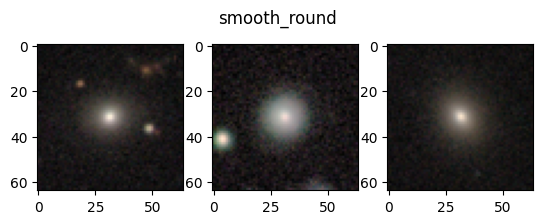

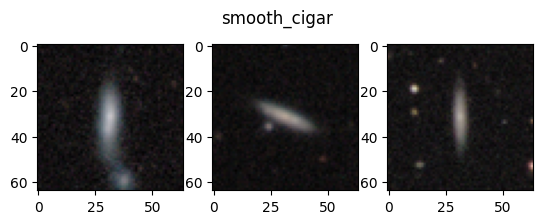

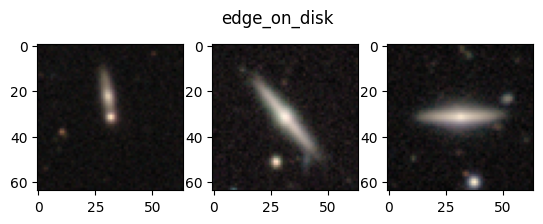

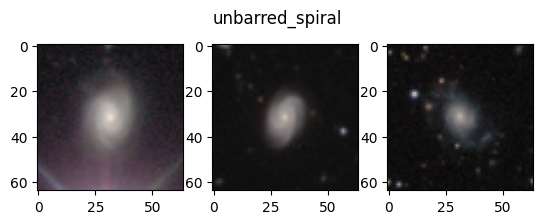

In [13]:
def plot_images(img_class, N):
    images = raw_images[labels==img_class][:N] # get images of class
    for i in range(N):
        ax = plt.subplot(1, N, i+1)
        ax.imshow(images[i].permute(1, 2, 0)) # Convert the original format of "Channel, Height, Width" to "Height, width, Channel"
    plt.subplots_adjust(top=1.4)
    plt.suptitle(dataset.classes[img_class])
    plt.show()

N = 3
for j in range(num_classes):
    plot_images(j, N)

The galaxy classes differ mainly in their shape and structure—ranging from round (elliptical), to elongated shape and to barred and spiral patterns.

tensor([22.3333, 27.0000, 13.3333,  ..., 13.6667,  8.3333, 21.3333])


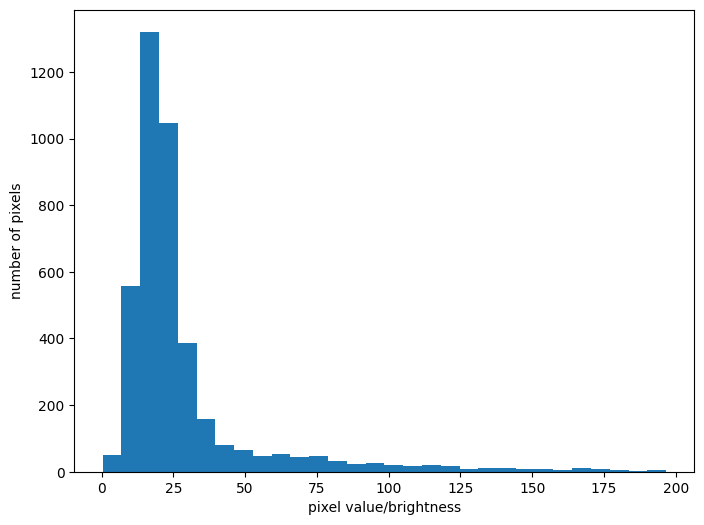

In [ ]:
sample_image = raw_images[0]
pixel_value = sample_image.sum(0).flatten()/3    # using sum(0)/3 to average over the three RGB channels, and then use flatten to let the 2-D pixel collapes in the 1-D

plt.figure(figsize=(8,6))
plt.hist(pixel_value, 30)    # 30 bins
plt.xlabel("pixel value/brightness")
plt.ylabel("number of pixels")

print(pixel_value)
plt.show()

## 1.2 Standardization of Data

Many machine learning models require or assume the input data to be standardized, meaning to have mean 0 and variance 1. However, there are multiple ways to achieve this for our dataset.
- What are the possible ways to standardize the data? (There is more than one way, think about the dimensions of the data.)
- Which one would you pick? Explain in one sentence why you picked it.
- Perform the standardization and check it. (You won't need a loop to achieve this.)

first of all there are two ways the data can be normalized: Minmax normalization $x_{\text{scaled}} = (x - min(x)) / (max(x) - min(x))$
 and Standarization $x_{\text{standard}} = (x - mean(x)) / std(x)$
. We think the latter one is better, in order to avoid the deviation under extrem min max values. And depending on our aim, we could standarize over all pixels in all images or per image, or per channel, or per pixel.

raw_images is assumed to be a 4D tensor of shape (N, C, H, W) Number, 3 Colors, Height, Width. .float() converts image pixel values for mean, std calculation. .mean(1) computes the average of RGB Channel.

tensor([[[-2.1910e-01, -3.7477e-02, -5.6938e-01,  ..., -5.1749e-01,
          -1.9316e-01, -2.9694e-01],
         [-4.7857e-01, -5.8235e-01, -7.7695e-01,  ..., -3.8775e-01,
          -4.0073e-01, -4.7857e-01],
         [-3.3586e-01, -7.6397e-02, -5.0450e-02,  ..., -6.3423e-02,
          -5.4343e-01, -5.0451e-01],
         ...,
         [-4.1370e-01, -1.0234e-01, -4.9154e-01,  ..., -5.8235e-01,
          -2.7100e-01, -2.5802e-01],
         [-7.6397e-02,  6.6309e-02, -4.5262e-01,  ..., -4.6559e-01,
          -6.9911e-01, -7.7695e-01],
         [-9.1966e-01, -6.0830e-01, -3.8775e-01,  ..., -5.5641e-01,
          -7.6398e-01, -2.5802e-01]],

        [[-3.4883e-01, -4.7857e-01, -4.0073e-01,  ..., -4.1370e-01,
          -2.9694e-01, -6.3425e-01],
         [-4.9154e-01, -5.9533e-01, -4.7857e-01,  ..., -4.2667e-01,
          -2.7100e-01, -6.4722e-01],
         [-3.6181e-01, -3.3586e-01, -5.6938e-01,  ..., -4.0073e-01,
          -3.8775e-01, -3.8775e-01],
         ...,
         [-4.0073e-01, -3

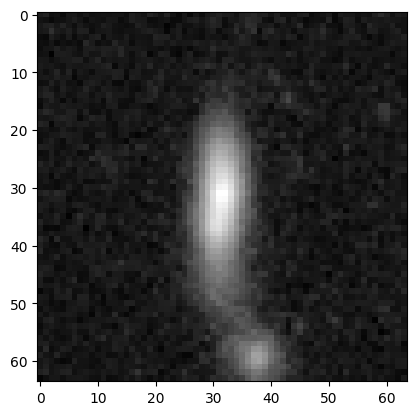

In [ ]:
gray_images = raw_images.float().mean(1)
gray_test_images = raw_test_images.float().mean(1)

normalized_images = (gray_images - gray_images.mean()) / gray_images.std()
normalized_test_images = (gray_test_images - gray_test_images.mean()) / gray_test_images.std()

#print(normalized_images)
print(normalized_images.mean(), normalized_images.std())
plt.imshow(normalized_images[0], cmap='gray')

## 1.3 k-Nearest Neighbors
A typical way to classify data is to use the [k-Nearest Neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). In this task we will start with a simple implementation and evaluation and improve upon that.
### 1.3.1 Naive k-NN
- Implement a k-NN classifier using one loop over the test set and another loop over the training set. Do not use a third loop to compute the image distances. You can use `tqdm` to show a progress bar for the outer loop to estimate the time it takes to classify the test set. If it would take too long, you can use a subset of the test set for this part.
- Bonus: Are there cases in which the classification criterion of k-nearest neighbors is ambiguous? Note what your implementation does in such cases.

Counter is used to count the occurrences of elements in a list or iterable. In KNN after finding the k nearest neighbor labels Counter helps count how many times each label appears.

In [ ]:
from tqdm import tqdm
from collections import Counter

def euclidean_metric(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def knn_predict(training_data, training_labels, test_point, k):
    distances = []
    for i in range(len(training_data)):
        dist = euclidean_metric(test_point, training_data[i])
        distances.append((dist, training_labels[i]))
    distances.sort(key=lambda x: x[0])                            # Sort the list of tuples by distance (smallest first)
    k_nearest_labels = [label for _, label in distances[:k]]      # take the first k-nearst neighbor
    return Counter(k_nearest_labels).most_common(1)[0][0]   

k = 15
pred_class = []
for test in tqdm(normalized_test_images.numpy()):
    pred_label = knn_predict(normalized_images.numpy(), labels.numpy(), test, k)     # using numpy() to convert tensor into array with 64x64 
    pred_class.append(pred_label)

100%|██████████| 2000/2000 [02:38<00:00, 12.62it/s]


### 1.3.2 Evaluation
Now that you have predictions, a meaningful way to evaluate the classifier is required.

- Read up on classification metrics. Describe the F1 score in one sentence. Why is it important to consider precision and recall together?
- Implement total accuracy (no loop needed). For reference, the accuracy achieved by your implementation with k=3 should be around 60%.
- Compare the results with sci-kit learns classification_report.
- Compute the confusion matrix. You may use [sklearn implementation](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions). What do you observe?
- Do we have a class imbalance in the dataset? If there was a class imbalance, what is the flaw in using total accuracy as a metric? What are the possible ways to address this issue?

Precision focuses on the proportion of true
positives among all positive predictions, while recall focuses on capturing all positive instances, minimizing false negatives. And F-score captures both information since it is high only if both values are high.

In [ ]:
pred_classes_tensor = torch.tensor(pred_class)     # classification matrix

acc = (pred_classes_tensor == test_labels).sum() / test_labels.shape[0]
print(f"Total accuracy: {acc*100:.4f}%")

for i in range(num_classes):
    true_positives = torch.logical_and((pred_classes_tensor == test_labels), (test_labels == i)).sum()
    precision = true_positives / (pred_classes_tensor == i).sum()
    recall = true_positives / (test_labels == i).sum()
    print(f"class: {dataset.classes[i]}     precision: {precision}      recall: {recall}")

Total accuracy: 63.6000%
class: smooth_round     precision: 0.6522948741912842      recall: 0.9250493049621582
class: smooth_cigar     precision: 0.5507246255874634      recall: 0.7509881258010864
class: edge_on_disk     precision: 0.6313725709915161      recall: 0.317554235458374
class: unbarred_spiral     precision: 0.7797619104385376      recall: 0.5458333492279053


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_labels, pred_classes_tensor, target_names=dataset.classes))
print(confusion_matrix(test_labels, pred_classes_tensor))

                 precision    recall  f1-score   support

   smooth_round       0.65      0.93      0.77       507
   smooth_cigar       0.55      0.75      0.64       506
   edge_on_disk       0.63      0.32      0.42       507
unbarred_spiral       0.78      0.55      0.64       480

       accuracy                           0.64      2000
      macro avg       0.65      0.63      0.62      2000
   weighted avg       0.65      0.64      0.62      2000

[[469   2   1  35]
 [ 24 380  83  19]
 [ 44 282 161  20]
 [182  26  10 262]]


the y-axis represent the true label, and the x-axis represent the predicted label

182 unbarred galaxies are misclassified as smooth round, and 282 edge-on galaxies are misclassified as cigar-shaped. On the other hand, only 35 smooth round galaxies are predicted as unbarred, and 83 cigar-shaped galaxies as edge-on. This results in an asymmetric confusion matrix. Which is natrual because the our kNN model is not unbiased and the asymmetry confirms it. The metric can only be symmetic, if balanced misclassification (e.g., class 0 → 1 and 1 → 0 happen equally). 

The support column represents the total number of true label for each classes. And since we have a close support for each class, the potential flaw of accuracy is avoided because each accuracy will be weighted equally in the total accuracy.

If imbalance did exist, here are common solutions: i) Resampling: Oversample minority classes and undersample majority classes

### 1.3.3 Faster k-NN
The double loop implementation computes all distances in sequence, which is slow. A faster way is to compute all distances at once using matrix operations.

- Implement a k-NN classifier that can compute distances between all test and training points at once either by using optimized distance computation functions by torch or scipy or similar libraries.
- Measure the run time of both implementations and write them down. For evaluation, we recommend using the classification report as well as the ConfusionMatrix from scikit-learn.

In [59]:
def get_sorted_distance(training_data, test_data):

    flat_training_data = training_data.view(training_data.shape[0], -1) # Flatten image tensors: (N_samples, C, H, W) → (N_samples, D), D=C x H x W number of color pixels
    flat_test_data = test_data.view(test_data.shape[0], -1) # shape (N_test_samples, D)
    
    distance = torch.cdist(flat_test_data, flat_training_data) # shape (N_test_samples, N_train_samples), distance calcul using matrix operations

    return torch.argsort(distance, dim=1) # shape (n_test_samples, n_train_samples)

def knn_classifier(k, sorted_distance):    # sorted_distance has shape (n_test,_samples, n_train_samples)
    
    nn_classes = [[labels[j].item() for j in i] for i in sorted_distance[:, :k]] # sorted_distance[:, :k] shape (n_test_samples, k), using item() to convert tensor eg. [1.] to number 1. 
    pred_classes = [max(set(i), key=i.count) for i in nn_classes] # shape n_test_samples
    
    return pred_classes

Each row sorted_distance[i] contains the indices of training samples sorted by increasing distance to test sample i. sorted_distance[:, :k] take the k nearest neighbor indices for each test sample, and then using labels[j] to get the corresponding class label from training data.

In [62]:
# Hyperparameter
k = 15

sorted_distance = get_sorted_distance(normalized_images, normalized_test_images)
pred_classes = knn_classifier(k, sorted_distance)
print(sorted_distance)

print(classification_report(test_labels, torch.tensor(pred_classes), target_names=dataset.classes))

tensor([[2695, 4212, 4063,  ..., 2546,  884, 1284],
        [6320, 6593, 4675,  ..., 2546,  884, 1284],
        [1434,  925,   53,  ...,  884, 2546, 1284],
        ...,
        [2986, 4642, 5986,  ..., 2546,  884, 1284],
        [3901, 6102, 5499,  ..., 2546,  920, 1284],
        [1598, 2124, 1038,  ..., 7481, 2546, 1284]])
                 precision    recall  f1-score   support

   smooth_round       0.64      0.93      0.76       507
   smooth_cigar       0.55      0.77      0.65       506
   edge_on_disk       0.65      0.31      0.42       507
unbarred_spiral       0.80      0.53      0.64       480

       accuracy                           0.64      2000
      macro avg       0.66      0.63      0.61      2000
   weighted avg       0.66      0.64      0.61      2000



### 1.3.4 Hyperparameter tuning
An important part of machine learning is hyperparameter tuning. But it can sometimes be tedious to tune hyperparameters by hand through numerous experiments. Fortunately, k-NN only has one hyperparameter.
- Determine based on the accuracy which k leads to the best classifier.
- Plot the accuracy against k.

Maximum accuracy at k=7. Accuracy: 64.20%


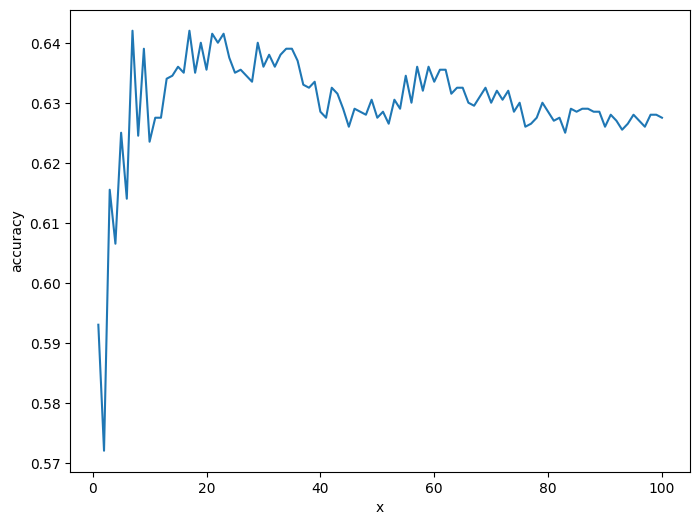

In [65]:
k_range = np.arange(1, 101)

predictions_k = [torch.tensor(knn_classifier(k, sorted_distance)) for k in k_range]

acc = [(pred == test_labels).sum() / test_labels.shape[0] for pred in predictions_k]

print(f"Maximum accuracy at k={k_range[np.argmax(acc)]}. Accuracy: {np.max(acc)*100:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(k_range, acc)
plt.ylabel('accuracy')
plt.xlabel('x')

plt.show()